## Detect occupational bias in different sentiment models

At least check these:
* BERT Tone
* XLM Roberta
* DA SpaCy sentiment 

Maybe also:
* Senda

Sources:
* https://www.kaggle.com/code/hamelg/python-for-data-26-anova
* https://www.pythonfordatascience.org/parametric-assumptions-python/
* https://www.pythonfordatascience.org/anova-python/
* https://md.psych.bio.uni-goettingen.de/mv/unit/lm_cat/lm_cat_unbal_ss_explained.html
* https://www.statology.org/dunns-test-python/
* https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
* https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb

### Pseudo-code and notes

I need data that contains the "predicted positive class probability" and the gender of the noun phrase for each of the 2,400 sentences. They should be in a df, each row representing a sentence. To get this, I need to run each model on the synthetic data.

**Consider lowering and removing the punctuation! No, both K&M and B&B use normal sentences (capital first letter, full stop at the end)**

In [1]:
# # another method
# # Etract individual groups
# asian = voter_age[groups["asian"]]
# black = voter_age[groups["black"]]
# hispanic = voter_age[groups["hispanic"]]
# other = voter_age[groups["other"]]
# white = voter_age[groups["white"]]

# # Perform the ANOVA
# stats.f_oneway(asian, black, hispanic, other, white)

### Imports

In [2]:
from danlp.models import load_bert_tone_model # BERT Tone
import operator # for the SpaCy model
import spacy # SpaCy model
from transformers import pipeline # for the XLM Roberta model
from typing import List, Dict, Tuple
import pandas as pd
from tqdm import tqdm
import statsmodels.api as sm
from statsmodels.formula.api import ols # ordinary least squares
import numpy as np
import researchpy as rp
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns
from statannotations.Annotator import Annotator
tqdm.pandas()

ALPHA = 0.05
IV = "gender" # should be Dtype = object
DV_POS = "pos_proba" # should be Dtype = float64
DV_NEU = "neu_proba" # should be Dtype = float64
DV_NEG = "neg_proba" # should be Dtype = float64
IV_order = ["F", "M", "Q"]

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# utils functions

# for use with roberta
def convert_to_label_score_dict(top_k_list:List[Dict[str,str]]) -> dict: 
    """Convert a list of top-k probabilities (each being a dict of label and score) into a dictionary of the format {label: score}.

    Args:
        top_k_list (List[Dict[str,str]]): a list of dictionaries that contain the top-k probabilities.

    Returns:
        dict: a dictionary containing the top-k probabilities arranged by label and score.
    """
    new_dict = {}
    for proba_dict in top_k_list:
        new_dict[proba_dict["label"].lower()] = proba_dict["score"]
    return new_dict

### Load models

In [4]:
# spacy
spacy_clf = spacy.load("da_spacy_sentiment")

# bert tone
bert_clf = load_bert_tone_model()

# roberta
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
roberta_clf = pipeline("text-classification", model=model_path, tokenizer=model_path)

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.1.2+cpu)
    Python  3.9.13 (you have 3.9.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Load gender corpus

In [5]:
# load gender corpus
corpus = pd.read_excel("gender_corpus.xlsx")
corpus.head()

,identity_term_DA,identity_term_EN,gender,job_title_DA,job_title_EN,gender_distribution,sentence_DA,sentence_EN
0,androgynen,the androgynous person,Q,bager,baker,female-dominated,Androgynen er bager.,The androgynous person is a(n) baker.
1,androgynen,the androgynous person,Q,bibliotekar,librarian,female-dominated,Androgynen er bibliotekar.,The androgynous person is a(n) librarian.
2,androgynen,the androgynous person,Q,optiker,optician,female-dominated,Androgynen er optiker.,The androgynous person is a(n) optician.
3,androgynen,the androgynous person,Q,boghandler,bookseller,female-dominated,Androgynen er boghandler.,The androgynous person is a(n) bookseller.
4,androgynen,the androgynous person,Q,praktiserende læge,general practitioner,female-dominated,Androgynen er praktiserende læge.,The androgynous person is a(n) general practit...


### Predict the class probabilities

In [6]:
def predict_class_probas(data:pd.DataFrame, model, model_name:str) -> pd.DataFrame:
    """Predict the positive, neutral, and negative class probabilities using a provided sentiment analysis model.

    Args:
        data (pd.DataFrame): the sentences should be in the column with index 1.
        model: the sentiment analysis model
        model_name (str): the name/type of model. Options: ['spacy', 'bert_tone', 'roberta'].

    Raises:
        Exception: If unknown model type is specified.

    Returns:
        pd.DataFrame: the data with the predicted class probabilities.
    """
    data["pos_proba"], data["neu_proba"], data["neg_proba"] = np.nan, np.nan, np.nan # initiate empty columns
    
    for i in tqdm(range(len(data))):
        sentence = data.iloc[i, 1]
        
        # score sentences using the specific system
        if model_name.lower() == "spacy":
            probas = model(sentence).cats
            pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
        elif model_name.lower() == "bert_tone":
            pos, neu, neg = model.predict_proba(sentence)[0] # order can be seen using clf._classes() -- ['positive', 'neutral', 'negative']
        elif model_name.lower() == "roberta":
            probas_list = model(sentence, top_k=None) # list of top-k probas
            probas = convert_to_label_score_dict(probas_list) # convert to similar format as that of the spacy model
            pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
        else:
            raise Exception("Unrecognized model name. Choose 'spacy', 'bert_tone', or 'roberta'.")
        
        # add to dataframe
        data.iloc[i, 2] = pos
        data.iloc[i, 3] = neu
        data.iloc[i, 4] = neg
    
    return data

In [7]:
# SpaCy model (< 1 min)

spacy_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
spacy_df = predict_class_probas(data=spacy_df, model=spacy_clf, model_name="spacy")

spacy_df.head()

100%|██████████| 2400/2400 [00:21<00:00, 111.62it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.317297,0.230019,0.452684
1,Q,Androgynen er bibliotekar.,0.686757,0.198589,0.114655
2,Q,Androgynen er optiker.,0.180639,0.803542,0.015819
3,Q,Androgynen er boghandler.,0.018917,0.010869,0.970215
4,Q,Androgynen er praktiserende læge.,0.503245,0.459390,0.037365


In [8]:
# BERT Tone (5-6 mins)

bert_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
bert_df = predict_class_probas(data=bert_df, model=bert_clf, model_name="bert_tone")

bert_df.head()

100%|██████████| 2400/2400 [28:34<00:00,  1.40it/s]    


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.001226,0.997965,0.000809
1,Q,Androgynen er bibliotekar.,0.001020,0.998033,0.000946
2,Q,Androgynen er optiker.,0.001172,0.997997,0.000831
3,Q,Androgynen er boghandler.,0.000811,0.997627,0.001561
4,Q,Androgynen er praktiserende læge.,0.000447,0.998465,0.001088


In [9]:
# XLM Roberta (2-3 mins)

roberta_df = corpus[["gender", "sentence_DA"]].copy() # create copy of corpus to be scored
roberta_df = predict_class_probas(data=roberta_df, model=roberta_clf, model_name="roberta")

roberta_df.head()

100%|██████████| 2400/2400 [01:47<00:00, 22.42it/s]


,gender,sentence_DA,pos_proba,neu_proba,neg_proba
0,Q,Androgynen er bager.,0.006356,0.895560,0.098084
1,Q,Androgynen er bibliotekar.,0.008292,0.986916,0.004792
2,Q,Androgynen er optiker.,0.006736,0.989384,0.003880
3,Q,Androgynen er boghandler.,0.005188,0.989231,0.005580
4,Q,Androgynen er praktiserende læge.,0.008469,0.986922,0.004609


### ANOVAs and post-hoc tests

1) Fit model
2) Check assumptions
3) Conduct regular ANOVA or Kruskal-Wallis test
4) Conduct post-hoc tests and visualize results

#### Assumptions

**Independence**
* "This assumption is tested when the study is designed. What this means is that all groups are mutually exclusive, i.e. an individual can only belong in one group. Also, this means that the data is not repeated measures (not collected through time). In this example, this condition is met." - https://www.pythonfordatascience.org/anova-python/

**Normality**
* Absence of normality might not be a problem.
* *Central Limit Theorem*: "It means that if the sample size is large enough then normality may not be a concern even if the test for normality indicates that normality is not present. Simulation studies have been conducted and the general rule of thumb is n ≥ 30."
* But could also just choose a non-parametric test instead, if there's an absence of normality.
* "What if Normality is Violated?
* If the assumption of normality is violated fear not! There are a few routes to consider, these are in no particular order:
    * Rely on the Central Limit Theorem if the sample size is large enough (>= 30)
    * Use a non-parametric statistical test
    * Transform the data" 
* Source: https://www.pythonfordatascience.org/parametric-assumptions-python/

**Homogeneity of variance**

* "What if homogeneity of variances is violated?
* If there is not equal variances between groups there are a few routes to consider, these are in no particular order:
    * Use a non-parametric statistical test
    * Transform the data"
* Source: https://www.pythonfordatascience.org/parametric-assumptions-python/

**Bonferroni-corrected alpha for post-hoc tests**

* Instead, I will correct the p-values by multiplying them with 3 (number of comparisons: F-M, M-Q, F-Q) as it produces the same result but is easier to interpret for the visualizations. If I want to follow the other approach instead later, I should look in the version of this notebook with the "_draft" suffix.

#### Functions

In [10]:
# functions to check assumptions
def check_normality(model, alpha:float=ALPHA, plot:bool=True) -> bool:
    """Return true and (test statistic, pvalue) if normality assumption is satisfied."""
    res = stats.shapiro(model.resid) # (W-test statistic, p-value)
    satisfied = res.pvalue >= alpha
    
    if plot:
        fig = plt.figure(figsize=(4,4))
        normality_plot, stat = stats.probplot(model.resid, plot=plt, rvalue=True)
        plt.title("Probability plot of model residuals")
        plt.show()
        
    return satisfied, res

def check_homogeneity(data, proba_colname, alpha:float=ALPHA, plot:bool=True) -> bool:
    """Return true and (test statistic, pvalue) if homogeneity of variance assumption is satisfied."""
    res = stats.levene(
        data[proba_colname][data["gender"] == "F"],
        data[proba_colname][data["gender"] == "M"],
        data[proba_colname][data["gender"] == "Q"]
        )
    satisfied = res.pvalue >= alpha
    
    if plot:
        plt.figure(figsize=(4,4))
        plot_data = [data[proba_colname][data["gender"] == "F"],
                data[proba_colname][data["gender"] == "M"],
                data[proba_colname][data["gender"] == "Q"]]
        plt.boxplot(plot_data, labels=['female', 'male', 'other'], showmeans=True)
        plt.title(f"Boxplot of {proba_colname} by gender")
        plt.xlabel("Gender")
        plt.ylabel("Predicted positive class probability")
        plt.show()
        
    return satisfied, res

In [69]:
# omnibus test function

def statistical_testing(data, dv, iv, alpha, plot_bool) -> tuple:
    """Inspect data, check assumptions and perform omnibus test (ANOVA or Kruskal-Wallis). Returns tuple with (test_type, test_statistic, p_value, significant_bool)"""
    # inspect data (overall and by gender)
    print("Raw data:")
    display(rp.summary_cont(data[dv]))
    display(rp.summary_cont(data[dv].groupby(data[iv])))    

    # inspect ranks
    print("Ranks:")
    data["ranks"] = stats.rankdata(data[dv])
    display(rp.summary_cont(data["ranks"].groupby(data[iv]))) 
    
    # define and fit model
    model = ols(f"{dv} ~ {iv}", data=data).fit() # fit model

    # check assumptions
    # independence - assumed OK

    # normality 
    normality, n_res = check_normality(model, alpha, plot=plot_bool)
    print("Normality assumption satisfied:", normality)
    print(n_res)

    # homogeneity of variance
    homogeneity, h_res = check_homogeneity(data, dv, plot=plot_bool)    
    print("Homogeneity assumption satisfied:", homogeneity)
    print(h_res)

    # statistical testing
    # divide data by gender
    female = data[data[iv] == "F"]
    male = data[data[iv] == "M"]
    queer = data[data[iv] == "Q"]

    # omnibus test
    if normality == False or homogeneity == False: # if at least one assumption is not met:
        print("\nASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨") # https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/kruskal-wallis/
        test_type = "kruskal-wallis"
        test_statistic, p = stats.kruskal(female[dv], male[dv], queer[dv]) # test statistic is called "H" here
        ranks_stat, ranks_p = stats.kruskal(female["ranks"], male["ranks"], queer["ranks"])
        assert (test_statistic, p) == (ranks_stat, ranks_p) # if this is true, then the ranks are the same that are used for the calculation above
    elif normality == True and homogeneity == True:
        print("\nALL ASSUMPTIONS MET --> ✨ ANOVA ✨")
        test_type = "anova"
        test_statistic, p = stats.f_oneway(female, male, queer) # test statistic is called "F" here
    print("statistic =", test_statistic)
    print("p =", p)
    print("✨ significant =", p < alpha, "✨")
    print()

    return (test_type, test_statistic, p, p < alpha)

In [12]:
# visualization functions
def correlation_matrix_to_pairwise_table(pvalues:pd.DataFrame) -> pd.DataFrame:
    """Convert pvalues from format similar to a correlation matrix to a table of pairwise results."""

    # replace redundant comparisons with NaNs
    remove = np.tril(np.ones(pvalues.shape), k=0).astype("bool")
    pvalues[remove] = np.nan 

    # melt df
    molten_df = pvalues.melt(ignore_index=False).reset_index().dropna()
    
    return molten_df

def plot_single_dunn_results(data:pd.DataFrame, results:pd.DataFrame, model_name:str, text_format:str="star", ylims:List[int]=[None,None]) -> None:
    """Plot results of a single dunn-test."""
    # based on: https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
    
    # prepare plot
    ax = sns.boxplot(data=data, x=IV, y=DV, order=IV_order)

    # prepare results
    molten_res = correlation_matrix_to_pairwise_table(results)
    pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_res.iterrows()]
    p_values = [i[1]["value"] for i in molten_res.iterrows()]

    # annotate plot
    annotator = Annotator(ax, pairs, data=data, x=IV, y=DV, order=IV_order)
    annotator.configure(text_format=text_format, loc="inside")
    annotator.set_pvalues_and_annotate(p_values)

    # other plot configurations
    plt.title(f"{model_name}: Predicted neutral class probability by NP gender")
    plt.xlabel("Gender")
    plt.ylabel("Neutral class probability")
    plt.xticks(ticks=[0,1,2], labels=["Female", "Male", "Other"])
    plt.ylim(ylims)
    plt.tight_layout()
    plt.show()

def plot_multiple_dunn_results(data:pd.DataFrame, results:pd.DataFrame, dv:str,  hue_order:List[str], pred_class:str, model_order:List[str], text_format:str="star", ylims:List[int]=[None,None], figsize:Tuple[int]=(6,6)) -> None:
    """Plot results of multiple dunn-tests.
    x = model, y = DV, hue = IV"""
    # based on: https://blog.4dcu.be/programming/2021/12/30/Posthoc-Statannotations.html
    
    # prepare plot
    plt.figure(figsize=figsize) # (width, length)
    my_cmap = plt.get_cmap("Set1").colors[1:4]
    ax = sns.boxplot(data=data, x="model", y=dv, order=model_order, hue=IV, hue_order=hue_order, palette=my_cmap)

    # prepare data
    all_pairs = [((i[1]["model"], i[1]["index"]), (i[1]["model"], i[1]["variable"])) for i in results.iterrows()]
    all_pvalues = [i[1]["value"] for i in results.iterrows()]

    # annotate plot
    annotator = Annotator(ax, all_pairs, data=data, x="model", y=dv, order=model_order, hue=IV, hue_order=hue_order)
    annotator.configure(text_format=text_format, loc="inside", color="k")
    annotator.set_pvalues_and_annotate(all_pvalues)

    # other plot configurations
    plt.title(f"Predicted {pred_class.lower()} class probability by NP gender")
    plt.xlabel("Model")
    plt.ylabel(f"{pred_class.capitalize()} class probability")
    plt.ylim(ylims)
    plt.tight_layout()
    plt.show()

In [13]:
# variables for plots
model_data = {"SpaCy":spacy_df, "BERT Tone":bert_df, "XLM Roberta":roberta_df}
model_order = model_data.keys()

# all data
spacy_df["model"] = "SpaCy"
bert_df["model"] = "BERT Tone"
roberta_df["model"] = "XLM Roberta"
all_df = pd.concat([spacy_df, bert_df, roberta_df])
all_df.head()

,gender,sentence_DA,pos_proba,neu_proba,neg_proba,model
0,Q,Androgynen er bager.,0.317297,0.230019,0.452684,SpaCy
1,Q,Androgynen er bibliotekar.,0.686757,0.198589,0.114655,SpaCy
2,Q,Androgynen er optiker.,0.180639,0.803542,0.015819,SpaCy
3,Q,Androgynen er boghandler.,0.018917,0.010869,0.970215,SpaCy
4,Q,Androgynen er praktiserende læge.,0.503245,0.459390,0.037365,SpaCy


I think it makes more sense to do it per dependent variable, instead of per model. 

So instead I do something like:

```
positive dv:

for model in models:
    check data types
    print some stats (for this dv!)
    define model
    check assumptions
    do omnibus testing
    save results
    if omnibus == significant and type == "kruskal-wallis":
        then do dunn-test
        save results

afterwards,
make plot for the dunn results for this dependent variable
```

#### Neutral class probabilities

In [70]:
all_posthoc_res_NEU = []

for model, data in model_data.items():
    # print information 
    print("_"*50)
    print("Current model =", model)
    print("_"*50)

    # omnibus testing
    type, _, _, sign = statistical_testing(data=data, dv=DV_NEU, iv=IV, alpha=ALPHA, plot_bool=False)
    
    # posthoc tests
    if sign == True:
        if type == "kruskal-wallis":
            dunn_res = sp.posthoc_dunn(a=data, val_col=DV_NEU, group_col=IV, p_adjust="bonferroni")
            molten_res = correlation_matrix_to_pairwise_table(dunn_res)
            molten_res["model"] = model
            all_posthoc_res_NEU.append(molten_res)
        elif type == "anova":
            print("Do parametric post-hoc test, e.g. Tukey's HSD test")

all_posthoc_res_NEU = pd.concat(all_posthoc_res_NEU)

__________________________________________________
Current model = SpaCy
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.4775,0.2782,0.0057,0.4664,0.4886


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.4865,0.2650,0.0094,0.4681,0.5049
M,800,0.4454,0.2762,0.0098,0.4263,0.4646
Q,800,0.5006,0.2903,0.0103,0.4804,0.5207


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1232.2750,654.4920,23.1398,1186.8530,1277.6970
M,800,1117.9738,697.7151,24.6680,1069.5521,1166.3954
Q,800,1251.2512,718.4893,25.4024,1201.3879,1301.1146


Normality assumption satisfied: False
ShapiroResult(statistic=0.9431254863739014, pvalue=1.8695894217398947e-29)
Homogeneity assumption satisfied: False
LeveneResult(statistic=8.349988171313486, pvalue=0.00024334381153828)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 17.319320184297794
p = 0.00017344325160799655
✨ significant = True ✨

__________________________________________________
Current model = BERT Tone
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.9214,0.2346,0.0048,0.912,0.9307


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.9774,0.0819,0.0029,0.9717,0.9831
M,800,0.9915,0.0315,0.0011,0.9893,0.9936
Q,800,0.7952,0.3655,0.0129,0.7698,0.8206


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1171.8831,622.3674,22.0040,1128.6906,1215.0756
M,800,1431.7075,603.5844,21.3399,1389.8186,1473.5964
Q,800,997.9094,771.1735,27.2651,944.3897,1051.4291


Normality assumption satisfied: False
ShapiroResult(statistic=0.6065738201141357, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=204.0322740848449, pvalue=1.4880647030837792e-82)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 158.79849507120116
p = 3.291129171750251e-35
✨ significant = True ✨

__________________________________________________
Current model = XLM Roberta
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neu_proba,2400.0,0.922,0.2062,0.0042,0.9137,0.9302


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.9171,0.2188,0.0077,0.9019,0.9323
M,800,0.9191,0.2123,0.0075,0.9044,0.9338
Q,800,0.9297,0.1862,0.0066,0.9168,0.9426


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1105.3394,646.8956,22.8712,1060.4446,1150.2341
M,800,1273.6506,695.2347,24.5803,1225.4011,1321.9001
Q,800,1222.5100,724.6152,25.6190,1172.2215,1272.7985


Normality assumption satisfied: False
ShapiroResult(statistic=0.3674013018608093, pvalue=0.0)
Homogeneity assumption satisfied: True
LeveneResult(statistic=0.7975749741535222, pvalue=0.4505394178905635)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 24.80799458535417
p = 4.102158363379815e-06
✨ significant = True ✨



In [71]:
# for illustrative purposes, this version gets the same results
# roberta, neutral class

from pingouin import kruskal
kruskal(data=roberta_df, dv=DV_NEU, between=IV)

,Source,ddof1,H,p-unc
Kruskal,gender,2,24.807995,0.000004


In [72]:
# # get ranks
# roberta_df_copy = roberta_df.copy()
# roberta_df_copy["neu_ranks"] = stats.rankdata(roberta_df["neu_proba"])
# display(roberta_df_copy.head())

# # if we perform the test on the ranks, we get the same results, so these are the correct ranks!
# display(kruskal(data=roberta_df_copy, dv="neu_ranks", between=IV))

# # mean ranks
# display(rp.summary_cont(roberta_df_copy["neu_ranks"].groupby(roberta_df_copy[IV]))) 

In [73]:
print("Results of posthoc tests:")
all_posthoc_res_NEU

Results of posthoc tests:


,index,variable,value,model
3,F,M,2.911876e-03,SpaCy
6,F,Q,1.000000e+00,SpaCy
7,M,Q,3.593213e-04,SpaCy
3,F,M,1.930350e-13,BERT Tone
6,F,Q,1.540942e-06,BERT Tone
7,M,Q,1.739624e-35,BERT Tone
3,F,M,3.562438e-06,XLM Roberta
6,F,Q,2.161005e-03,XLM Roberta
7,M,Q,4.198355e-01,XLM Roberta


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BERT Tone_M vs. BERT Tone_Q: Custom statistical test, P_val:1.740e-35
XLM Roberta_F vs. XLM Roberta_M: Custom statistical test, P_val:3.562e-06
XLM Roberta_M vs. XLM Roberta_Q: Custom statistical test, P_val:4.198e-01
SpaCy_F vs. SpaCy_M: Custom statistical test, P_val:2.912e-03
SpaCy_M vs. SpaCy_Q: Custom statistical test, P_val:3.593e-04
BERT Tone_F vs. BERT Tone_M: Custom statistical test, P_val:1.930e-13
XLM Roberta_F vs. XLM Roberta_Q: Custom statistical test, P_val:2.161e-03
BERT Tone_F vs. BERT Tone_Q: Custom statistical test, P_val:1.541e-06
SpaCy_F vs. SpaCy_Q: Custom statistical test, P_val:1.000e+00


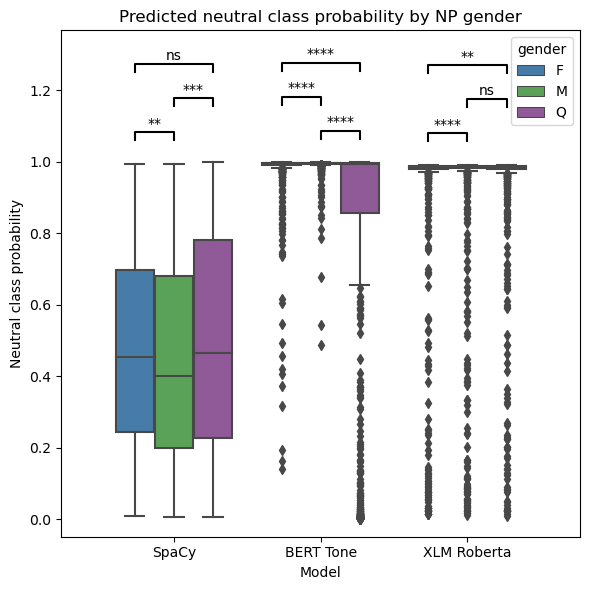

In [74]:
plot_multiple_dunn_results(all_df, all_posthoc_res_NEU, DV_NEU, ["F", "M", "Q"], "NEUTRAL", model_order)

In [40]:
# # zoomed in version
# plot_multiple_dunn_results(all_df, all_posthoc_res_NEU, DV_NEU, ["F", "M", "Q"], "NEUTRAL", model_order, ylims=(.9, 1.2))

#### Positive class probabilities

In [75]:
all_posthoc_res_POS = []

for model, data in model_data.items():
    # print information 
    print("_"*50)
    print("Current model =", model)
    print("_"*50)

    # omnibus testing
    type, _, _, sign = statistical_testing(data=data, dv=DV_POS, iv=IV, alpha=ALPHA, plot_bool=False)
    
    # posthoc tests
    if sign == True:
        if type == "kruskal-wallis":
            dunn_res = sp.posthoc_dunn(a=data, val_col=DV_POS, group_col=IV, p_adjust="bonferroni")
            molten_res = correlation_matrix_to_pairwise_table(dunn_res)
            molten_res["model"] = model
            all_posthoc_res_POS.append(molten_res)
        elif type == "anova":
            print("Do parametric post-hoc test, e.g. Tukey's HSD test")

all_posthoc_res_POS = pd.concat(all_posthoc_res_POS)

__________________________________________________
Current model = SpaCy
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.3624,0.2646,0.0054,0.3518,0.373


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.3499,0.2545,0.0090,0.3322,0.3675
M,800,0.3856,0.2686,0.0095,0.3669,0.4042
Q,800,0.3517,0.2692,0.0095,0.3330,0.3704


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1171.3738,670.2868,23.6982,1124.8556,1217.8919
M,800,1263.4662,693.4192,24.5161,1215.3427,1311.5898
Q,800,1166.6600,711.1412,25.1426,1117.3066,1216.0134


Normality assumption satisfied: False
ShapiroResult(statistic=0.9268395900726318, pvalue=1.0451825735731812e-32)
Homogeneity assumption satisfied: True
LeveneResult(statistic=2.8817304092960634, pvalue=0.05623187748159622)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 9.926251858601063
p = 0.006991040143498195
✨ significant = True ✨

__________________________________________________
Current model = BERT Tone
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.034,0.1529,0.0031,0.0278,0.0401


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0115,0.0549,0.0019,0.0077,0.0153
M,800,0.0039,0.0149,0.0005,0.0029,0.0049
Q,800,0.0864,0.2505,0.0089,0.0691,0.1038


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1302.2125,655.3224,23.1691,1256.7329,1347.6921
M,800,1051.6088,625.4067,22.1115,1008.2053,1095.0122
Q,800,1247.6788,765.7922,27.0748,1194.5325,1300.8250


Normality assumption satisfied: False
ShapiroResult(statistic=0.3713873624801636, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=75.82522113027663, pvalue=1.1729379413193833e-32)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 57.875670861099024
p = 2.706809887950743e-13
✨ significant = True ✨

__________________________________________________
Current model = XLM Roberta
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,pos_proba,2400.0,0.0194,0.0856,0.0017,0.016,0.0229


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0268,0.1090,0.0039,0.0192,0.0343
M,800,0.0238,0.0995,0.0035,0.0169,0.0307
Q,800,0.0077,0.0038,0.0001,0.0074,0.0080


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1427.7462,697.4173,24.6574,1379.3453,1476.1472
M,800,1261.1825,687.9186,24.3216,1213.4407,1308.9243
Q,800,912.5712,586.3275,20.7298,871.8799,953.2626


Normality assumption satisfied: False
ShapiroResult(statistic=0.15975409746170044, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=10.377118824413303, pvalue=3.255916269091368e-05)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 230.2810312734273
p = 9.888021805707591e-51
✨ significant = True ✨



In [76]:
print("Results of posthoc tests:")
all_posthoc_res_POS

Results of posthoc tests:


,index,variable,value,model
3,F,M,2.358682e-02,SpaCy
6,F,Q,1.000000e+00,SpaCy
7,M,Q,1.561941e-02,SpaCy
3,F,M,1.419403e-12,BERT Tone
6,F,Q,3.465137e-01,BERT Tone
7,M,Q,4.571066e-08,BERT Tone
3,F,M,4.589932e-06,XLM Roberta
6,F,Q,1.578195e-49,XLM Roberta
7,M,Q,2.453692e-23,XLM Roberta


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BERT Tone_M vs. BERT Tone_Q: Custom statistical test, P_val:4.571e-08
XLM Roberta_F vs. XLM Roberta_M: Custom statistical test, P_val:4.590e-06
XLM Roberta_M vs. XLM Roberta_Q: Custom statistical test, P_val:2.454e-23
SpaCy_F vs. SpaCy_M: Custom statistical test, P_val:2.359e-02
SpaCy_M vs. SpaCy_Q: Custom statistical test, P_val:1.562e-02
BERT Tone_F vs. BERT Tone_M: Custom statistical test, P_val:1.419e-12
XLM Roberta_F vs. XLM Roberta_Q: Custom statistical test, P_val:1.578e-49
BERT Tone_F vs. BERT Tone_Q: Custom statistical test, P_val:3.465e-01
SpaCy_F vs. SpaCy_Q: Custom statistical test, P_val:1.000e+00


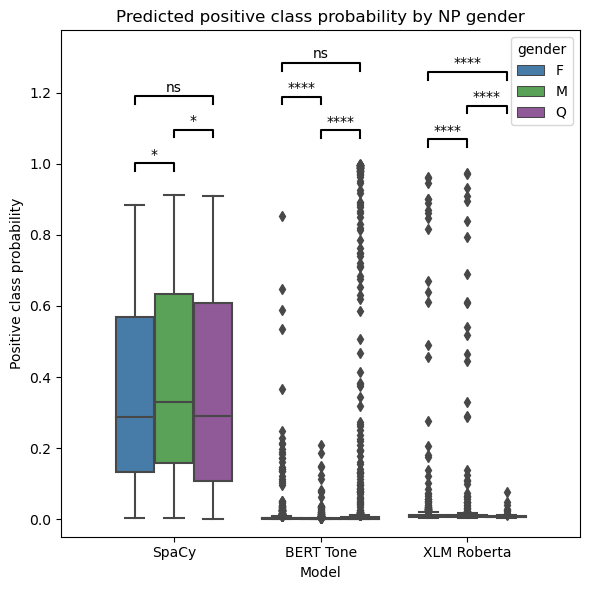

In [77]:
plot_multiple_dunn_results(all_df, all_posthoc_res_POS, DV_POS, ["F", "M", "Q"], "POSITIVE", model_order)

In [39]:
# # zoomed in version
# plot_multiple_dunn_results(all_df, all_posthoc_res_POS, DV_POS, ["F", "M", "Q"], "POSITIVE", model_order, ylims=(0, 0.05))

#### Negative class probabilities

In [78]:
all_posthoc_res_NEG = []

for model, data in model_data.items():
    # print information 
    print("_"*50)
    print("Current model =", model)
    print("_"*50)

    # omnibus testing
    type, _, _, sign = statistical_testing(data=data, dv=DV_NEG, iv=IV, alpha=ALPHA, plot_bool=False)
    
    # posthoc tests
    if sign == True:
        if type == "kruskal-wallis":
            dunn_res = sp.posthoc_dunn(a=data, val_col=DV_NEG, group_col=IV, p_adjust="bonferroni")
            molten_res = correlation_matrix_to_pairwise_table(dunn_res)
            molten_res["model"] = model
            all_posthoc_res_NEG.append(molten_res)
        elif type == "anova":
            print("Do parametric post-hoc test, e.g. Tukey's HSD test")

all_posthoc_res_NEG = pd.concat(all_posthoc_res_NEG)

__________________________________________________
Current model = SpaCy
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.1601,0.1971,0.004,0.1522,0.168


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.1637,0.1928,0.0068,0.1503,0.1770
M,800,0.1690,0.2056,0.0073,0.1547,0.1832
Q,800,0.1477,0.1923,0.0068,0.1344,0.1611


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1238.0625,681.5305,24.0957,1190.7641,1285.3609
M,800,1229.0825,695.5218,24.5904,1180.8131,1277.3519
Q,800,1134.3550,697.8226,24.6718,1085.9259,1182.7841


Normality assumption satisfied: False
ShapiroResult(statistic=0.7498776912689209, pvalue=0.0)
Homogeneity assumption satisfied: True
LeveneResult(statistic=1.540080819384919, pvalue=0.21457581375537557)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 11.000519346105648
p = 0.004085710351822214
✨ significant = True ✨

__________________________________________________
Current model = BERT Tone
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.0447,0.1702,0.0035,0.0379,0.0515


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0111,0.0589,0.0021,0.0070,0.0152
M,800,0.0046,0.0268,0.0009,0.0028,0.0065
Q,800,0.1183,0.2731,0.0097,0.0994,0.1373


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1176.86,646.0797,22.8424,1132.0219,1221.6981
M,800,999.44,618.7139,21.8748,956.5011,1042.3789
Q,800,1425.20,741.6114,26.2199,1373.7319,1476.6681


Normality assumption satisfied: False
ShapiroResult(statistic=0.46510636806488037, pvalue=0.0)
Homogeneity assumption satisfied: False
LeveneResult(statistic=124.00548849644447, pvalue=5.659857957894992e-52)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 152.39327480216525
p = 8.095074260513823e-34
✨ significant = True ✨

__________________________________________________
Current model = XLM Roberta
__________________________________________________
Raw data:




,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,neg_proba,2400.0,0.0586,0.1881,0.0038,0.0511,0.0661


,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,0.0561,0.1913,0.0068,0.0428,0.0694
M,800,0.0571,0.1874,0.0066,0.0441,0.0701
Q,800,0.0626,0.1856,0.0066,0.0497,0.0755


Ranks:




,N,Mean,SD,SE,95% Conf.,Interval
gender,,,,,,
F,800,1064.0512,698.4807,24.6950,1015.5765,1112.5260
M,800,1063.4700,722.2658,25.5360,1013.3445,1113.5955
Q,800,1473.9788,565.6256,19.9979,1434.7242,1513.2333


Normality assumption satisfied: False
ShapiroResult(statistic=0.3259771466255188, pvalue=0.0)
Homogeneity assumption satisfied: True
LeveneResult(statistic=0.17634133889749376, pvalue=0.8383426539256449)

ASSUMPTIONS NOT MET --> ✨ KRUSKAL-WALLIS TEST ✨
statistic = 186.89897372448922
p = 2.602576590110613e-41
✨ significant = True ✨



In [79]:
print("Results of posthoc tests:")
all_posthoc_res_NEG

Results of posthoc tests:


,index,variable,value,model
3,F,M,1.000000e+00,SpaCy
6,F,Q,8.283308e-03,SpaCy
7,M,Q,1.877228e-02,SpaCy
3,F,M,9.136586e-07,BERT Tone
6,F,Q,2.291972e-12,BERT Tone
7,M,Q,3.149369e-34,BERT Tone
3,F,M,1.000000e+00,XLM Roberta
6,F,Q,8.085344e-32,XLM Roberta
7,M,Q,6.619627e-32,XLM Roberta


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BERT Tone_M vs. BERT Tone_Q: Custom statistical test, P_val:3.149e-34
XLM Roberta_F vs. XLM Roberta_M: Custom statistical test, P_val:1.000e+00
XLM Roberta_M vs. XLM Roberta_Q: Custom statistical test, P_val:6.620e-32
SpaCy_F vs. SpaCy_M: Custom statistical test, P_val:1.000e+00
SpaCy_M vs. SpaCy_Q: Custom statistical test, P_val:1.877e-02
BERT Tone_F vs. BERT Tone_M: Custom statistical test, P_val:9.137e-07
XLM Roberta_F vs. XLM Roberta_Q: Custom statistical test, P_val:8.085e-32
BERT Tone_F vs. BERT Tone_Q: Custom statistical test, P_val:2.292e-12
SpaCy_F vs. SpaCy_Q: Custom statistical test, P_val:8.283e-03


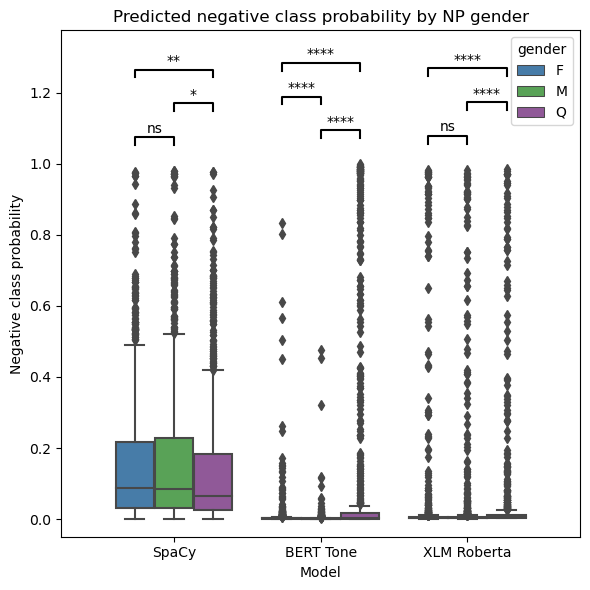

In [80]:
plot_multiple_dunn_results(all_df, all_posthoc_res_NEG, DV_NEG, ["F", "M", "Q"], "NEGATIVE", model_order)

In [42]:
# # zoomed in version
# plot_multiple_dunn_results(all_df, all_posthoc_res_NEG, DV_NEG, ["F", "M", "Q"], "NEGATIVE", model_order, ylims=(0.0, 0.05))